# Ноутбук для экспериментов

In [89]:
import functools
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%config InlineBackend.figure_format = 'svg'

# Реализация вспомогательных функций и структур

In [2]:
# MAGIC CONSTANTS

HEXAGON_PARTICLE_THRESHOLD = 0.012

YELLOW_LOWER = np.array([17, 155, 155])
YELLOW_UPPER = np.array([35, 255, 255])

RED_LOWER = np.array([0, 153, 134])
RED_UPPER = np.array([9, 255, 255])

BLUE_LOWER = np.array([25, 0, 0])
BLUE_UPPER = np.array([255, 73, 200])

HEXAGON_ANGLE_EPSILON = 5

LEAVE_ONLY_BIG_CONTOURS = 0.2

BIG_COMPONONETS_RATIO = 6

In [3]:
COUNTER_TYPES = {
    '1': {
        'blue': ['crossed', 0, 2],
        'red': ['full', 1, 3],
        'yellow': ['full', 4, 5]
    },
    '2': {
        'blue': ['full', 0, 3],
        'red': ['full', 4, 5],
        'yellow': ['full', 1, 2]
    },
    '3': {
        'blue': ['full', 0, 5],
        'red': ['full', 3, 4],
        'yellow': ['full', 1, 2]
    },
    '4': {
        'blue': ['crossed', 0, 3],
        'red': ['full', 2, 4],
        'yellow': ['crossed', 1, 5]
    },
    '5': {
        'blue': ['full', 4, 5],
        'red': ['full', 0, 3],
        'yellow': ['full', 1, 2]
    },
    '6': {
        'blue': ['full', 2, 4],
        'red': ['crossed', 1, 5],
        'yellow': ['crossed', 0, 3]
    },
    '7': {
        'blue': ['full', 4, 5],
        'red': ['full', 1, 3],
        'yellow': ['crossed', 0, 2]
    },
    '8': {
        'blue': ['full', 4, 5],
        'red': ['crossed', 0, 2],
        'yellow': ['full', 1, 3]
    },
    '9': {
        'blue': ['full', 2, 4],
        'red': ['crossed', 0, 3],
        'yellow': ['crossed', 1, 5]
    },
    '10': {
        'blue': ['full', 1, 3],
        'red': ['crossed', 0, 2],
        'yellow': ['full', 4, 5]
    }
}

In [4]:
def DrawPolygon(ImShape, Polygon, Color):
    Im = np.zeros(ImShape, np.uint8)
    cv2.fillConvexPoly(Im, Polygon, Color)
    return Im


def Get2PolygonIntersectArea(ImShape, Polygon1, Polygon2):
    Im1 = DrawPolygon(ImShape[:-1], Polygon1, 122)
    Im2 = DrawPolygon(ImShape[:-1], Polygon2, 133)
    Im = Im1 + Im2
    _, OverlapIm = cv2.threshold(Im, 200, 255, cv2.THRESH_BINARY)
    
    IntersectArea = np.sum(np.greater(OverlapIm, 0))
    contours, _ = cv2.findContours(OverlapIm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0.0, None
    
    contourArea = cv2.contourArea(contours[0])
    perimeter = cv2.arcLength(contours[0], True)
    
    return IntersectArea, perimeter, OverlapIm, contourArea

In [5]:
def apply_funcs(original_img, funcs):
    current_img = original_img.copy()
    for func in funcs:
        current_img = func(current_img)
    return current_img

def opening(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    return wrapper

def closing(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    return wrapper

def dilate(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.dilate(img, kernel, iterations=1)
    
    return wrapper

def erode(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.erode(img, kernel, iterations=1)
    
    return wrapper

def threshold(low, high, is_invert=False):
    mode = cv2.THRESH_BINARY_INV if is_invert else cv2.THRESH_BINARY
    
    def wrapper(img):
        _, img_thr = cv2.threshold(img, low, high, mode)
        return img_thr
    
    return wrapper

def change_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def bgr_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def gauss_blur(n, sigma=0):
    def wrapper(img):
        return cv2.GaussianBlur(img, (n, n), sigma)
    
    return wrapper

def kirshe_operator(img):
    def rotate(arr):
        n = arr.shape[0]
        res = np.array(arr)
        res[0, :n - 1] = arr[0, 1:n]
        res[1:n, 0] = arr[:n - 1, 0]
        res[n - 1, 1:n] = arr[n - 1, :n - 1]
        res[:n - 1, n - 1] = arr[1:n, n - 1]
        return res
    
    kernel = np.array([
        [-3, -3, 5],
        [-3, 0, 5],
        [-3, -3, 5]
    ])
    kernels = []
    for _ in range(8):
        kernels.append(kernel)
        kernel = rotate(kernel)
    
    imgs = [np.abs(cv2.filter2D(img, -1, kernel)) for kernel in kernels] 
    return functools.reduce(np.maximum, imgs, np.zeros(img.shape, dtype=np.uint8))

def find_contours(img):
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy

def leave_only_main_contours(args):
    contours, hierarchy = args
    return [contour for i, contour in enumerate(contours) if hierarchy[0, i, 3] == -1]

def leave_only_area_threshold_contours(threshold, inv=False):
    def wrapper(contours):
        if not inv:
            return list(filter(lambda x: cv2.contourArea(x) >= threshold, contours))
        else:
            return list(filter(lambda x: cv2.contourArea(x) < threshold, contours))
    
    return wrapper

def leave_only_hexagon_similar_contours(contours):
    return contours

def leave_only_big_contours(contours):
    areas = np.array([cv2.contourArea(contour) for contour in contours])
    threshold = LEAVE_ONLY_BIG_CONTOURS * areas.max()
    inds = np.arange(len(contours))[areas >= threshold]
    return [contours[idx] for idx in inds]
    

def draw_contours(img, contours):
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    return image_copy

def get_convex_contours(contours):
    return [cv2.convexHull(contour, False) for contour in contours]

def canny(low, high):
    def wrapper(img):
        return cv2.Canny(img, low, high)
    
    return wrapper

def get_masked_image(img, contour, erosion=None, is_convex=True):
    mask = np.zeros(img.shape, dtype=np.uint8)
    if is_convex:
        cv2.fillConvexPoly(mask, contour, (255, 255, 255))
    else:
        cv2.fillPoly(mask, contour, (255, 255, 255))
    if erosion is not None:
        mask = erode(erosion)(mask)
    return cv2.bitwise_and(img, mask)

def show(img, show_=True):
    max_edge = 8.0
    alpha = max_edge / max(img.shape[0], img.shape[1])
    size = (alpha * img.shape[1], alpha * img.shape[0])
    plt.figure(figsize=size)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(change_rgb(img))
    if show_:
        plt.show()
    
def bitwise_or(imgs):
    res = imgs[0]
    for img in imgs[1:]:
        res = cv2.bitwise_or(res, img)
    return res

def bitwise_and(imgs):
    res = imgs[0]
    for img in imgs[1:]:
        res = cv2.bitwise_and(res, img)
    return res

def mask_all_contours(img, contours, eroding_val=15):
    return bitwise_or([get_masked_image(img, contour, eroding_val) for contour in contours])

def find_blue(img, contours=None):
    hsv = bgr_to_hsv(img)
    mask = cv2.inRange(hsv, BLUE_LOWER, BLUE_UPPER)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def find_yellow(img, contours=None):
    hsv = bgr_to_hsv(img)
    mask = cv2.inRange(hsv, YELLOW_LOWER, YELLOW_UPPER)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def find_red(img, contours=None):
    hsv = bgr_to_hsv(img)
    mask = cv2.inRange(hsv, RED_LOWER, RED_UPPER)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def get_blue_contours(img):
    contours = apply_funcs(bgr_to_gray(img), hexagons)
    blue = find_blue(img, contours)
    blue = apply_funcs(blue, [closing(7)])
    threshold = HEXAGON_PARTICLE_THRESHOLD * np.array([cv2.contourArea(contour) for contour in contours]).mean()
    blue_contours = apply_funcs(blue, convex_figures + [leave_only_area_threshold_contours(threshold)])
    
    return blue_contours

def get_yellow_contours(img):
    contours = apply_funcs(bgr_to_gray(img), hexagons)
    preprocessed_color = apply_funcs(img, [gauss_blur(5), closing(5)])
    yellow = find_yellow(preprocessed_color, contours)
    yellow = apply_funcs(yellow, [closing(7)])
    threshold = HEXAGON_PARTICLE_THRESHOLD * np.array([cv2.contourArea(contour) for contour in contours]).mean()
    yellow_contours = apply_funcs(yellow, convex_figures + [leave_only_area_threshold_contours(threshold)])
    
    return yellow_contours

def get_red_contours(img):
    contours = apply_funcs(bgr_to_gray(img), hexagons)
    preprocessed_color = apply_funcs(img, [gauss_blur(5), closing(5)])
    red = find_red(preprocessed_color, contours)
    red = apply_funcs(red, [closing(7)])
    threshold = HEXAGON_PARTICLE_THRESHOLD * np.array([cv2.contourArea(contour) for contour in contours]).mean()
    red_contours = apply_funcs(red, convex_figures + [leave_only_area_threshold_contours(threshold)])
    
    return red_contours

def xiufu(img_gray, img):
    _, mask = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY)
    res_ = cv2.resize(img, None, fx=0.6, fy=0.6, interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask, None, fx=0.6, fy=0.6, interpolation=cv2.INTER_CUBIC)
    dst = cv2.inpaint(res_, mask, 10, cv2.INPAINT_TELEA)

    return dst

def get_rect(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    return np.int0(box)

def draw_text(img, text, coords, thickness=2, color=(0, 255, 0), fontScale=1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    img_copy = img.copy()
    cv2.putText(img_copy, text, coords, font, fontScale, color, thickness, cv2.LINE_AA)
    return img_copy

def distance(X, Y):
    answer = np.linalg.norm(X, axis=-1)[:, None] ** 2 + \
        np.linalg.norm(Y, axis=-1)[None, :] ** 2 - (2.0 * X) @ Y.T
    answer[answer < 0] = 0
    return np.sqrt(answer)

def get_simplified_hexagon(contour):
    contour = contour.reshape(-1, 2)
    N = contour.shape[0]
    if N < 6:
        return None
    sharp_angles_far_180 = []
    
    for i in range(-2, N - 2):
        c1, c2, c3 = contour[i], contour[i + 1], contour[i + 2]
        v1 = np.array(c1 - c2, dtype=float)
        v2 = np.array(c3 - c2, dtype=float)
        arccos = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        if np.abs(180 / np.pi * arccos - 180) > HEXAGON_ANGLE_EPSILON:
            sharp_angles_far_180.append(c2)
    
    X = np.array(np.hstack(sharp_angles_far_180).reshape(-1, 2), dtype=float)
    points = KMeans(n_clusters=6).fit(X).cluster_centers_
    
    dists = distance(points, X)
    points = np.array(points, dtype=np.int32)
    indices = dists.argmin(axis=1).argsort()
    points = points[indices, :]
    
    return np.array(points.reshape(-1, 1, 2))

In [14]:
# Превращает изображения с темными фигурами на светлом фоне в изображения с белыми фигурами на черном фоне
# При этом светлые пятна внутри фигур остаются как черные пятна
white_figures = [gauss_blur(5), threshold(100, 255, True)]
# white_figures = [gauss_blur(5), threshold(100, 255, True)]

# Получение изображения с хорошими границами
borders = white_figures + [kirshe_operator]

# Получение выпуклых фигур на изображении
# Если изображение далеко от идельного, что допускает довольно плотную линию, обволакивающую некоторые нужные фигуры,
# то они потеряются
convex_figures = [find_contours, leave_only_main_contours, get_convex_contours]

# Отлично находить темные шестиугольники на светлом фоне
# hexagons = borders + convex_figures + [leave_only_big_contours, leave_only_hexagon_similar_contours]
hexagons = white_figures + convex_figures + [leave_only_big_contours, leave_only_hexagon_similar_contours]

In [8]:
def get_mean_perimeter(counters):
    return np.array([cv2.arcLength(counter['hex'], True) for counter in counters]).mean()

def get_mean_area(counters):
    return np.array([cv2.contourArea(counter['hex']) for counter in counters]).mean()

def try_to_make_better_color(contours, hex_contour):
    areas = np.array([cv2.contourArea(contour) for contour in contours])
    inds = areas.argsort()
    areas = areas[inds]
    contours = [contours[idx] for idx in inds]
    if len(contours) == 2:
        if areas[0] / areas[1] <= 1 / BIG_COMPONONETS_RATIO:
            contours = contours[1:]
    return contours

def get_counters(img):
    hex_contours = apply_funcs(bgr_to_gray(img), hexagons)
    blue = get_blue_contours(img)
    yellow = get_yellow_contours(img)
    red = get_red_contours(img)
    
    def find_best(contour):
        over = np.array([Get2PolygonIntersectArea(img.shape, h, contour)[0] for h in hex_contours])
        arg = over.argmax()
        if np.nonzero(over[arg]):
            return arg
        return None
    
    result = [
        {'hex': hex_contour, 'blue': [], 'yellow': [], 'red': []}
        for hex_contour in hex_contours
    ]
    
    for color_contour in blue:
        arg = find_best(color_contour)
        if arg is not None:
            result[arg]['blue'].append(color_contour)
    for color_contour in yellow:
        arg = find_best(color_contour)
        if arg is not None:
            result[arg]['yellow'].append(color_contour)
    for color_contour in red:
        arg = find_best(color_contour)
        if arg is not None:
            result[arg]['red'].append(color_contour)
    
    for counter in result:
        for col in ['blue', 'yellow', 'red']:
            counter[col] = try_to_make_better_color(counter[col], counter['hex'])
    
    return result

def repair_color_by_2_others(state, missed_color):
    def dist_mod_6(a, b):
        return min(abs(a - b), 6 - abs(a - b))
    
    fulled = set(range(6))
    not_missed_coords = []
    not_missed_colors = []
    for col, val in state.items():
        if col != missed_color:
            not_missed_colors.append(col)
            not_missed_coords.append(val[1:])
            fulled.discard(val[1])
            fulled.discard(val[2])
    fulled = sorted(fulled)
    
    if len(fulled) != 2:
        return
    
    dist = dist_mod_6(*fulled)
    if dist == 1:
        state[missed_color] = ['full'] + fulled
    elif dist == 2:
        mid = (fulled[0] + 1) % 6 if fulled[1] < 4 else (fulled[1] + 1) % 6
        for col, val in state.items():
            if col != missed_color:
                if mid in val[1:]:
                    mid = col
        mode = 'full' if state[mid][0] == 'crossed' else 'crossed'
        state[missed_color] = [mode] + fulled
    elif dist_mod_6(*not_missed_coords[0]) == 1:
        state[missed_color] = ['full'] + fulled
    elif state[not_missed_colors[0]][0] == 'crossed' and state[not_missed_colors[1]][0] == 'crossed':
        state[missed_color] = ['full'] + fulled
    else:
        state[missed_color] = ['crossed'] + fulled

def determine_counter_state(counter):
    simple_hex = get_simplified_hexagon(counter['hex'])
    if simple_hex is None:
        raise NotImplementedError('Less than 6 points')
    simple_hex = simple_hex.reshape(-1, 2)
    hex_means = np.array(simple_hex, dtype=float)
    hex_means[:-1, :] += simple_hex[1:, :]
    hex_means[-1, :] += simple_hex[0, :]
    hex_means /= 2
        
    state = {}
    missed_colors = []
    for col in ['blue', 'yellow', 'red']:
        blocks = counter[col]
        if len(blocks) == 0 or len(blocks) >= 3:
            missed_colors.append(col)
            state[col] = None
            continue
        elif len(blocks) == 1:
            rect = get_rect(blocks[0]).reshape(-1, 2)
            len1 = np.linalg.norm(rect[0] - rect[1])
            len2 = np.linalg.norm(rect[0] - rect[3])
            if len1 < len2:
                rect = rect[[3, 0, 1, 2], :]
            mean1 = (rect[1] + rect[2]) / 2
            mean2 = (rect[0] + rect[3]) / 2
            state[col] = ['full']
        else:
            rect1 = get_rect(blocks[0]).reshape(-1, 2)
            rect2 = get_rect(blocks[1]).reshape(-1, 2)
            mean1 = rect1.mean(axis=0)
            mean2 = rect2.mean(axis=0)
            state[col] = ['crossed']
        arg1 = np.linalg.norm(hex_means - mean1[None, :], axis=1).argmin()
        arg2 = np.linalg.norm(hex_means - mean2[None, :], axis=1).argmin()
        state[col] += sorted([arg1, arg2])
        
    if len(missed_colors) >= 2:
        raise NotImplementedError('I am unsure in two or more colors')
    elif len(missed_colors) == 1:
        repair_color_by_2_others(state, missed_colors[0])
        
    return state, np.array(hex_means, dtype=np.int32)

def determine_counter_type(state):
    if state['blue'] is None or state['yellow'] is None or state['red'] is None:
        return -1
    
    unique = set()
    for val in state.values():
        unique.add(val[1])
        unique.add(val[2])
    if sorted(unique) != list(range(6)):
        return -1
    
    permutation = list(range(6))
    
    def do_permutation():
        return {
            col: [val[0]] + sorted([permutation[val[1]], permutation[val[2]]])
            for col, val in state.items()
        }
    
    def do_shift():
        save = permutation[0]
        permutation[:-1] = permutation[1:]
        permutation[-1] = save
    
    for name, counter_type in COUNTER_TYPES.items():
        for _ in range(6):
            cur = do_permutation()
            if cur == counter_type:
                return name, counter_type
            do_shift()
    
    return -1

def get_counter_type(counter):
    try:
        state, _ = determine_counter_state(counter)
        t = {'default': determine_counter_type(state)}
    except NotImplementedError:
        t = {'default': -1}
    
    if t['default'] == -1:
        for col in ['blue', 'yellow', 'red']:
            save = counter[col]
            counter[col] = []
            name = 'del_{}'.format(col)
            try:
                state, _ = determine_counter_state(counter)
            except NotImplementedError:
                t[name] = -1
            else:
                t[name] = determine_counter_type(state)
            if t[name] != -1:
                return t[name]
            counter[col] = save
    
    return t['default']

# Ввод и предобработка изображения

In [93]:
filename = 'images/Group_3.bmp'

In [94]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(filename, cv2.IMREAD_COLOR)

In [95]:
alpha = 1.5
width = round(img.shape[1] * alpha)
height = round(img.shape[0] * alpha)
scale = (width, height)
img = cv2.resize(img, scale, interpolation=cv2.INTER_CUBIC)
img_color = cv2.resize(img_color, scale, interpolation=cv2.INTER_CUBIC)

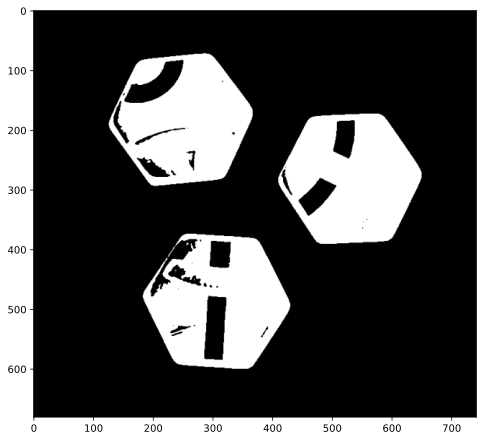

In [96]:
show(apply_funcs(img, white_figures))

# Эксперименты и демонстрации

### Часть с экспериментами над различными свертками, блюрами и прочим для определения оптимальной последовательности действий забыта потеряна, удалена за ненадобностью и очевидностью.

## Отображение всех деталей вместе и по отдельности для каждой фишки

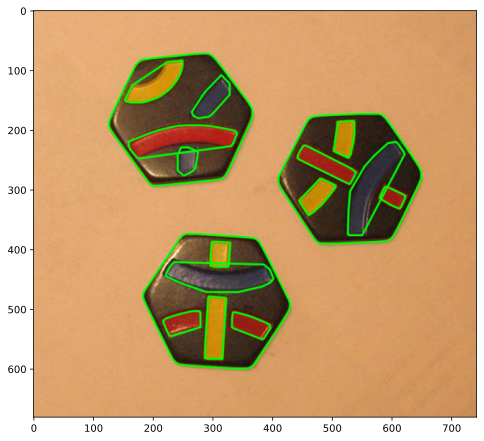

In [97]:
contours = apply_funcs(img, hexagons)
blue = get_blue_contours(img_color)
yellow = get_yellow_contours(img_color)
red = get_red_contours(img_color)
show(draw_contours(img_color, contours + blue + red + yellow))

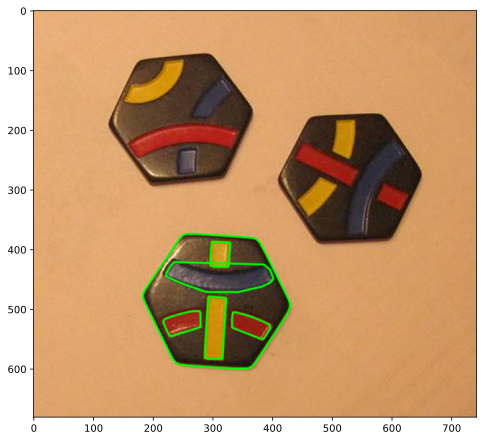

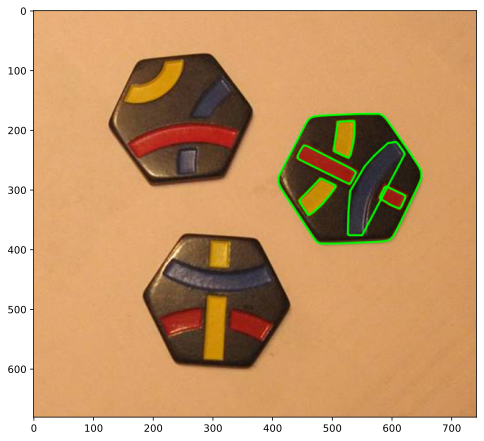

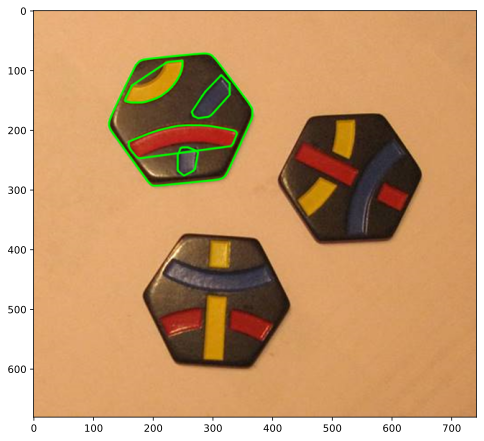

In [98]:
for smth in get_counters(img_color):
    show(draw_contours(img_color, [smth['hex']] + smth['blue'] + smth['yellow'] + smth['red']))

## Обволакивание контуров компонет фишек в прямоугольники

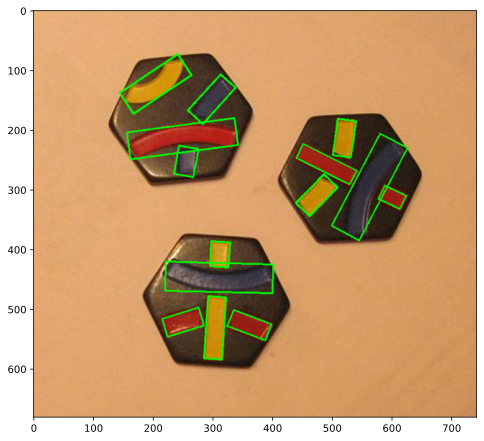

In [90]:
copy_img = img_color.copy()
for contour in blue + yellow + red:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(copy_img, [box], 0, (0, 255, 0), 2)
show(copy_img)

In [92]:
cv2.imwrite(
    'rect_example.bmp',
    cv2.resize(copy_img, (m, n), interpolation=cv2.INTER_CUBIC)
)

True

## Определение угловых точек шестиугольников

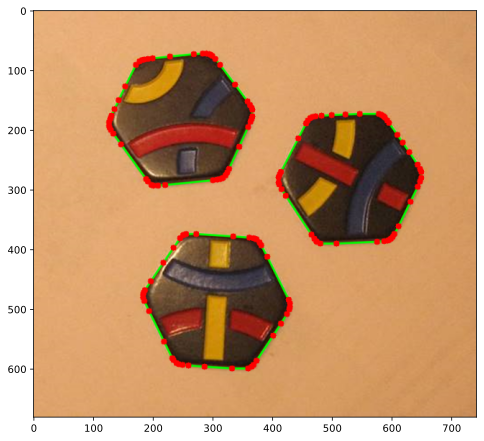

True

In [99]:
temp = img_color.copy()
for contour in contours:
    temp = draw_contours(temp, [contour])
    for idx in range(contour.shape[0]):
        cv2.circle(temp, contour[idx].ravel(), 5, (0 , 0, 255), -1)
show(temp)
cv2.imwrite(
    'contour_points_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

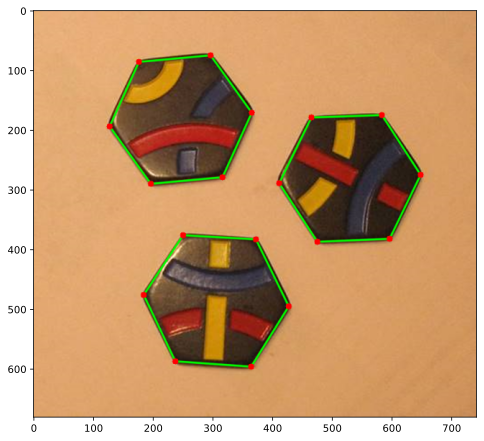

True

In [88]:
temp = img_color.copy()
for contour in contours:
    smth = get_simplified_hexagon(contour)
    temp = draw_contours(temp, [smth])
    for idx in range(smth.shape[0]):
        cv2.circle(temp, smth[idx].ravel(), 5, (0 , 0, 255), -1)
show(temp)
cv2.imwrite(
    'hex_points_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

## Определение типа фишки

In [76]:
counters = get_counters(img_color)

In [77]:
c = counters[0]

In [78]:
c['blue'] = []

In [79]:
determine_counter_type(c)

('6',
 {'blue': ['full', 2, 4],
  'red': ['crossed', 1, 5],
  'yellow': ['crossed', 0, 3]})

## Создание картинки, с размеченными типами, рабочая версия

In [31]:
filename = 'images/Group_3.bmp'
img_color = cv2.imread(filename, cv2.IMREAD_COLOR)

In [32]:
n, m, _ = img_color.shape
alpha = round(np.sqrt(1250000 / (n * m)))

width = round(img_color.shape[1] * alpha)
height = round(img_color.shape[0] * alpha)
scale = (width, height)
img_color = cv2.resize(img_color, scale, interpolation=cv2.INTER_CUBIC)

In [25]:
counters = get_counters(img_color)
types = [get_counter_type(counter) for counter in counters]

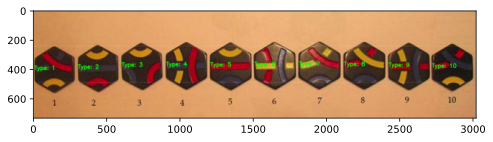

In [26]:
temp = img_color
bugs = []

perimeter = get_mean_perimeter(counters)
side = round(perimeter / 6)

for counter, t in zip(counters, types):
    if t == -1:
        print('blin')
        bugs.append(counter)
        continue
    
    M = cv2.moments(counter['hex'])
    coords = (
        round(M['m10'] / M['m00']) - round(side * np.sqrt(3) / 2),
        round(M['m01'] / M['m00'])
    )
    
    temp = draw_text(temp, 'Type: {}'.format(t[0]), coords, thickness=4, fontScale=1.25)
show(temp)

In [106]:
blue = get_blue_contours(img_color)
yellow = get_yellow_contours(img_color)
red = get_red_contours(img_color)
temp = draw_contours(img_color, blue + red + yellow)
cv2.imwrite(
    'cont_col_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

True

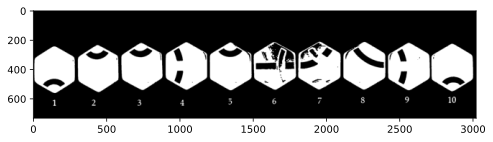

In [12]:
show(apply_funcs(img, white_figures[1:-1]))

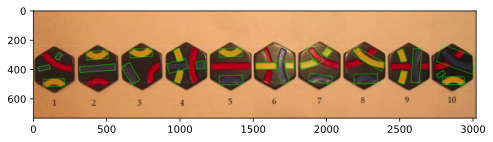

In [13]:
copy_img = img_color.copy()
for contour in blue + yellow + red:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(copy_img, [box], 0, (0, 255, 0), 2)
show(copy_img)

In [60]:
def add_3(img):
    res = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    res.ravel()[::3] = img.ravel()
    res.ravel()[1::3] = img.ravel()
    res.ravel()[2::3] = img.ravel()
    return res

In [63]:
temp = find_blue(img_color)
temp = add_3(temp)
temp = draw_contours(temp, get_blue_contours(img_color))
cv2.imwrite(
    'blue_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

True

In [69]:
temp = find_yellow(img_color)
temp = add_3(temp)
temp = draw_contours(temp, get_yellow_contours(img_color))
cv2.imwrite(
    'yellow_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

True

In [70]:
temp = find_red(img_color)
temp = add_3(temp)
temp = draw_contours(temp, get_red_contours(img_color))
cv2.imwrite(
    'red_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

True

In [67]:
temp = apply_funcs(bgr_to_gray(img_color), white_figures)
temp = add_3(temp)
temp = draw_contours(temp, apply_funcs(bgr_to_gray(img_color), hexagons))
cv2.imwrite(
    'hex_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

True

In [72]:
contours = apply_funcs(bgr_to_gray(img_color), hexagons)
blue = get_blue_contours(img_color)
yellow = get_yellow_contours(img_color)
red = get_red_contours(img_color)
temp = draw_contours(img_color, contours + blue + red + yellow)

cv2.imwrite(
    'hex_example.bmp',
    cv2.resize(temp, (m, n), interpolation=cv2.INTER_CUBIC)
)

True